In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import mplotutils as mpu
import cartopy.crs as ccrs
from netCDF4 import Dataset
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from cartopy.feature import NaturalEarthFeature
from matplotlib.colors import from_levels_and_colors, ListedColormap
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords, get_cartopy, interpline

%matplotlib inline

# Vertical Cross-section

In [31]:
def cross_section(variable_name, date, time, 
                    start_lat, start_lon, 
                    end_lat, end_lon, save=False):
    
    '''This function plots a vertical cross section of the chosen 
    variable. Supported variables for plotting procedure are 
    vertical_velocity, rh, omega, absolute_vorticity, theta_e and
    reflectivity.'''
    
    # Define data filename
    filename = '/scratch3/thomasl/work/data/casestudy_baden/' \
                'wrfout_d02_{}_{}:00'.format(date, time)
    
    # Create the start point and end point for the cross section
    start_point = CoordPair(lat=start_lat, lon=start_lon)
    end_point = CoordPair(lat=end_lat, lon=end_lon)
    
    ### Start plotting procedure ###
    # Open NetCDF file
    ncfile = Dataset(filename)

    # Extract the model height, terrain height and variables
    ht = getvar(ncfile, 'z')/1000 # change to km
    ter = getvar(ncfile, 'ter')/1000
    
    if variable_name == 'vertical_velocity': 
        variable = getvar(ncfile, 'wa', units='kt')
        title_name = 'Vertical Velocity'
        colorbar_label = 'Vertical Velocity [$kn$]'
        variable_min = -2
        variable_max = 2
    
    elif variable_name == 'rh':
        variable = getvar(ncfile, 'rh')
        title_name = 'Relative Humidity'
        colorbar_label = 'Relative Humidity [$pct$]'
        variable_min = 0
        variable_max = 105
    
    elif variable_name == 'omega':
        variable = getvar(ncfile, 'omega')
        title_name = 'Vertical Motion (Omega)'
        colorbar_label = 'Omega [$Pa$ $s^-$$^1$]'
        variable_min = -5
        variable_max = 5
        
        
    elif variable_name == 'absolute_vorticity':
        variable = getvar(ncfile, 'avo')
        title_name = 'Absolute Vorticity'
        colorbar_label = 'Absolute Vorticity [$10^{-5}$' \
                            '$s^{-1}$]'
        variable_min = -50
        variable_max = 100
        
    elif variable_name == 'theta_e':
        variable = getvar(ncfile, 'theta_e')
        title_name = 'Theta-E'
        colorbar_label = 'Theta-E [$K$]'
        variable_min = 315
        variable_max = 335
        
    elif variable_name == 'reflectivity':
        variable = getvar(ncfile, 'dbz')#, timeidx=-1
        title_name = 'Reflectivity'
        colorbar_label = 'Reflectivity [$dBZ$]'
        variable_min = 5
        variable_max = 75     
    
    # Linear Z for interpolation 
    Z = 10**(variable/10)
    
    # Compute the vertical cross-section interpolation
    z_cross = vertcross(Z, ht, wrfin=ncfile,
                    start_point=start_point,
                    end_point=end_point,
                    latlon=True, meta=True)
    
    # Convert back after interpolation
    variable_cross = 10.0 * np.log10(z_cross)

    # Make a copy of the z cross data
    variable_cross_filled = np.ma.copy(to_np(variable_cross))

    # For each cross section column, find the first index with 
    # non-missing values and copy these to the missing elements below
    for i in range(variable_cross_filled.shape[-1]):
        column_vals = variable_cross_filled[:,i]
        first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
        variable_cross_filled[0:first_idx, i] = variable_cross_filled[first_idx, i]

    ter_line = interpline(ter, wrfin=ncfile, start_point=start_point,
                      end_point=end_point)
    
    # Get latitude and longitude points
    lats, lons = latlon_coords(variable)

    # Create the figure
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes()
    
    ys = to_np(variable_cross.coords['vertical'])
    xs = np.arange(0, variable_cross.shape[-1], 1)

    # Make contour plot
    if variable_name == 'reflectivity':
        levels = np.arange(variable_min, variable_max, 5)
        
        # Create the dbz color table found on NWS pages.
        dbz_rgb = np.array([[4,233,231],
                            [1,159,244], [3,0,244],
                            [2,253,2], [1,197,1],
                            [0,142,0], [253,248,2],
                            [229,188,0], [253,149,0],
                            [253,0,0], [212,0,0],
                            [188,0,0],[248,0,253],
                            [152,84,198]], np.float32) / 255.0

        dbz_cmap, dbz_norm = from_levels_and_colors(levels, dbz_rgb,
                                                   extend='max')
    
    else:
        levels = np.linspace(variable_min, variable_max, 21)
    
    if variable_name == 'omega' or variable_name == 'vertical_velocity':
        def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
            new_cmap = colors.LinearSegmentedColormap.from_list(
                'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, 
                                                    b=maxval),
                cmap(np.linspace(minval, maxval, n)))
            return new_cmap

        old_cmap = plt.get_cmap('RdYlBu_r')
        cmap = truncate_colormap(old_cmap, 0.05, 0.9)

        norm = colors.DivergingNorm(vmin=variable_min, vcenter=0, vmax=variable_max)

    else:
        cmap = ListedColormap(sns.cubehelix_palette(20, start=.5, rot=-.75))
    
    if variable_name == 'omega' or variable_name == 'vertical_velocity':
        variable_contours = ax.contourf(xs, ys, 
                                        to_np(variable_cross_filled), 
                                        levels=levels, cmap=cmap, 
                                        extend='both', norm=norm)
    
    elif variable_name == 'rh':
        variable_contours = ax.contourf(xs, ys, 
                                        to_np(variable_cross_filled), 
                                        levels=levels, cmap=cmap, 
                                        extend='max')
    elif variable_name == 'reflectivity':
        variable_contours = ax.contourf(xs, ys, 
                                        to_np(variable_cross_filled), 
                                        levels=levels, cmap=dbz_cmap, 
                                        norm=dbz_norm, extend='both')    
    
    else:
        variable_contours = ax.contourf(xs, ys, 
                                        to_np(variable_cross_filled), 
                                        levels=levels, cmap=cmap, 
                                        extend='both')
    # Plot wind barbs     
    if variable_name == 'vertical_velocity':
        u = getvar(ncfile, 'ua', units='kt')
        
        U = 10**(u/10)
        
        u_cross = vertcross(U, ht, wrfin=ncfile, 
                                   start_point=start_point, 
                                   end_point=end_point, latlon=True, 
                                   meta=True)  
        
        u_cross = 10.0 * np.log10(u_cross)
        
        u_cross_filled = np.ma.copy(to_np(u_cross))

        for i in range(u_cross_filled.shape[-1]):
            column_vals = u_cross_filled[:,i]
            first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
            u_cross_filled[0:first_idx, i] = u_cross_filled[first_idx, i]
        
        ax.barbs(xs[::3], ys[::3], to_np(u_cross_filled[::3, ::3]), 
                 to_np(variable_cross_filled[::3, ::3]), length=7, zorder=1)

    # Add color bar
    cbar = mpu.colorbar(variable_contours, ax, orientation='vertical', 
                        aspect=40, shrink=.05, pad=0.05)
    cbar.set_label(colorbar_label, fontsize=15)
    cbar.set_ticks(levels)

    # Set x-ticks to use latitude and longitude labels
    coord_pairs = to_np(variable_cross.coords['xy_loc'])
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [pair.latlon_str(fmt='{:.2f}, {:.2f}')
                for pair in to_np(coord_pairs)]
    
    # Set desired number of x ticks below
    num_ticks = 5
    thin = int((len(x_ticks) / num_ticks) + .5)
    ax.set_xticks(x_ticks[::thin])
    ax.set_xticklabels(x_labels[::thin], rotation=45, fontsize=10)
    ax.set_xlim(x_ticks[0], x_ticks[-1])
    
    # Set y-ticks and limit the height
    ax.set_yticks(np.linspace(0,12,13))
    ax.set_ylim(0, 12)

    # Set x-axis and y-axis labels
    ax.set_xlabel('Latitude, Longitude', fontsize=12.5)
    ax.set_ylabel('Height [$km$]', fontsize=12.5)
    
    # Fill in mountian area
    ht_fill = ax.fill_between(xs, 0, to_np(ter_line),
                                facecolor='saddlebrown', zorder=2)
    
    # Make nicetime
    xr_file = xr.open_dataset(filename)
    nicetime = pd.to_datetime(xr_file.QVAPOR.isel(Time=0).XTIME.values)
    
    # Add title
    ax.set_title('Vertical Cross-Section of {}'.format(title_name), fontsize=20, 
                 loc='left')
    ax.set_title('Valid time: {} {}'.format(nicetime.strftime('%Y-%m-%d %H:%M'), 'UTC'), 
                 fontsize= 15, loc='right')
        
    # Add grid for y axis
    if variable_name == 'omega':
        grid_color = 'w'
    
    else:
        grid_color = 'grey'
    
    ax.grid(axis='y', linestyle='--', color=grid_color)
    
    plt.show()
    
    ### Save figure ###
    if save == True:
        fig.savefig('/scratch3/thomasl/work/retrospective_part/' \
                'casestudy_baden/cross_section/cross_section_' \
                '{}.pdf'.format(variable_name), bbox_inches='tight')

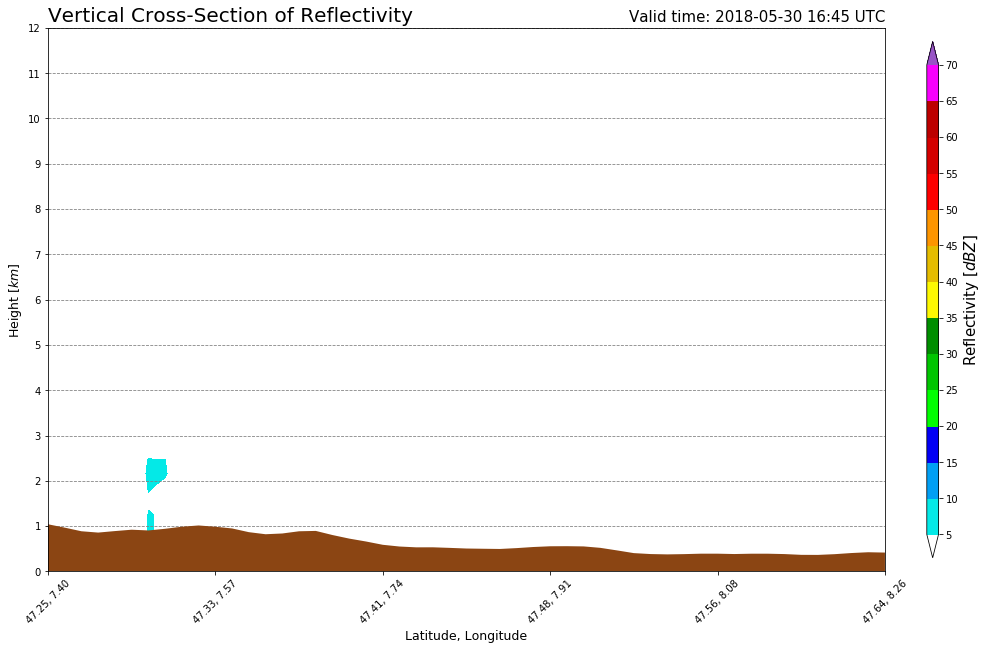

In [32]:
cross_section('reflectivity', '2018-05-30', 
                '16:45', 47.25, 7.4, 47.25, -1.5, 
              save=False)